In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os


# Load data

In [3]:
df_all = pd.read_csv('eua_price_data_High_Low.csv', thousands=',') 
df_all['Date'] = pd.to_datetime(df_all['Date'], format='%Y-%m-%d')  
df_all = df_all.sort_values(by = 'Date', ascending=True).reset_index(drop = True)
df_all = df_all[(df_all['Date'] > pd.to_datetime('2020-11-24'))].reset_index(drop=True)

# Preprocessing & train/test data split

In [4]:
from script.curate_training_test_data import  curate_training_test_data_many

predictors_lst =['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean', 'High_price', 'Low_price']
test_date = '2024-07-23' 

folder_name = "result_ml_sklearn"
modeltype = 'knn'
if os.path.isdir(folder_name) is not True:
    os.mkdir(folder_name)
sequence_length = 28
checkpoint_path = f"./{folder_name}/{modeltype}_ts_{sequence_length}.skl"

last_train_date = pd.to_datetime(test_date) - pd.to_timedelta(1, unit = 'day')
X_train, y_train, X_test, y_test, scaler = curate_training_test_data_many(
                                            df_all, 
                                            flatten=True,
                                            sequence_length_input=28,  # 입력 시퀀스 길이 (30일)
                                            sequence_length_out=28,    # 입력 시퀀스 길이 (30일)
                                            test_date=test_date,
                                            predictors_lst=predictors_lst,
                                            dtype = 'float32',
                                            is_test_split = True,
                                            )


In [6]:
import pickle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

models = {
    'lr':LinearRegression() ,
    'ridge': Ridge(),
    'lasso': Lasso(),
    'dt':DecisionTreeRegressor(),
    'rf':RandomForestRegressor(),
    'gb':GradientBoostingRegressor(),
    'knn':KNeighborsRegressor()
}
# Define the hyperparameter search grid
param_grids = {
    'lr': {
    'fit_intercept': [True, False],
},
    'ridge': {
    'alpha': [0.1, 1, 10, 100],
    'fit_intercept': [True, False],
},
    'lasso':{
    'alpha': [0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'max_iter': [1000, 5000, 10000]
},
    'dt':
        {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 5, 7],
    'max_features': [None, 'sqrt']
},
    'rf':{
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
},
    'gb':{
    'n_estimators': [10, 50, 10],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
},
    
    'knn':{'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'algorithm': ['ball_tree', 'kd_tree', 'brute']}
}

for key in models.keys():
    if os.path.isfile(f'best_mutistep_{key}_model.skl') == False:
        grid_search = GridSearchCV(models[key], param_grids[key], 
                                cv=3, 
                                scoring='neg_mean_squared_error',
                                )
        grid_search.fit(X_train, y_train)

        model = grid_search.best_estimator_
        model.fit(X_train, y_train)
        with open(f'best_mutistep_{key}_model.skl', 'wb') as f:
            pickle.dump(model, f)
            
    print(f'... {key} is done.')

... lr is done.
... ridge is done.
... lasso is done.
... dt is done.
... rf is done.


ValueError: 
All the 729 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
729 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_gb.py", line 437, in fit
    y = column_or_1d(y, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1202, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (854, 224) instead.


In [ ]:
key = 'knn'
with open(f'best_mutistep_{key}_model.skl', 'rb') as f :
    model = pickle.load(f)

In [21]:
# prediction for train/validation data
y_train_pred = model.predict(X_train)
y_test_pred =  model.predict(X_test)

y_test_preds = []
for i in range(10):
    y_test_preds.append(model.predict(X_test))

In [23]:
from script.post_processing import inverse_scaler_of_all_var
y_train_pred = inverse_scaler_of_all_var(y_train_pred, scaler).reshape(-1,sequence_length,len(predictors_lst))
y_test_pred  = inverse_scaler_of_all_var(y_test_pred, scaler).reshape(-1,sequence_length,len(predictors_lst))
y_test_preds = [i.reshape(-1,sequence_length,len(predictors_lst)) for i in inverse_scaler_of_all_var(y_test_preds, scaler)]
y_train_true = inverse_scaler_of_all_var(y_train, scaler).reshape(-1,sequence_length,len(predictors_lst))
y_test_true  = inverse_scaler_of_all_var(y_test, scaler).reshape(-1,sequence_length,len(predictors_lst))

In [24]:
# define start of train date and valid/train split date
train_start_date =  df_all['Date'][0] + pd.to_timedelta(28, unit = 'day')
train_test_split_date = pd.to_datetime(test_date)

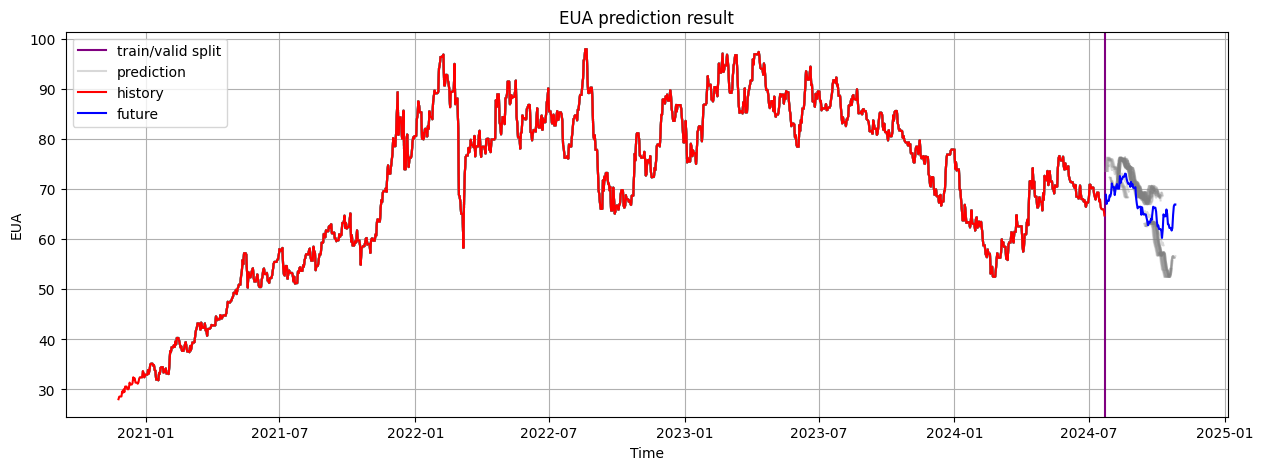

In [25]:
# visuals of train/validation data prediction (single prediction)
from script.post_processing import visual_train_n_valid_data_performance
visual_train_n_valid_data_performance(y_train_pred,y_test_pred, 
                                      train_start_date, train_test_split_date, df_all,
                                      decoration = {'xlabel': 'Time', 
                                                    'ylabel':'EUA', 
                                                    'title':'EUA prediction result',
                                                    'grid':'on'})


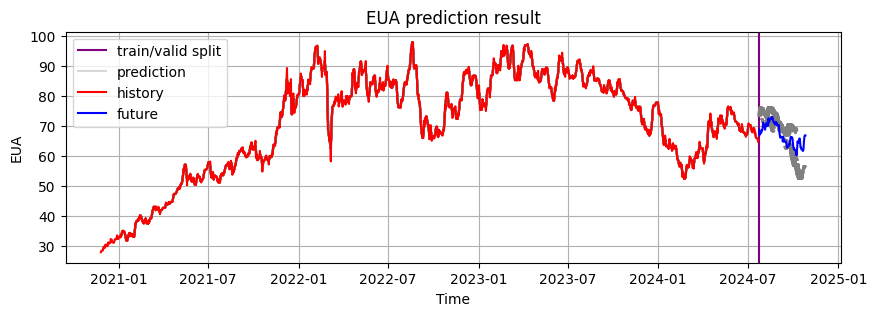

In [13]:
# visual ensemble of predictions
visual_train_n_valid_data_performance(y_train_pred,y_test_preds, train_start_date, train_test_split_date, df_all,
                                      figsize = (10,3),
                                      index_of_data = 0,
                                      name_of_data = 'EUA',
                                      decoration = {'xlabel': 'Time', 
                                                    'ylabel':'EUA', 
                                                    'title':'EUA prediction result',
                                                    'grid':'on'})

In [15]:
# 2. add recursive scheme
from script.post_processing import resursive_furture_prediction_in_sklearn
future_price_ensemble, future_time = resursive_furture_prediction_in_sklearn(model, 
                                                                            y_test[-1],
                                                                            train_test_split_date = df_all['Date'].max(),
                                                                            num_of_ensemble = 1,
                                                                            scaler = scaler,
                                                                            df_all = df_all,
                                                                            flatten  = True)

In [16]:
from script.post_processing import visual_recursive_future_prediction_plotly
visual_recursive_future_prediction_plotly(future_time, future_price_ensemble,
                                       train_test_split_date,
                                       df_all,
                                          
                                          index_of_data= 0, # 0 is EUA price
                                          name_of_data = 'EUA',
                                        decoration = {'xlabel': 'Time', 
                                                        'ylabel':'EUA', 
                                                        'title':'EUA prediction result',
                                                        'grid':'on'})
                                          

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



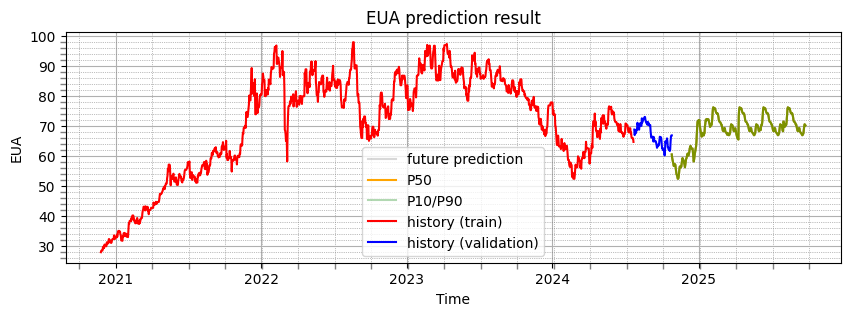

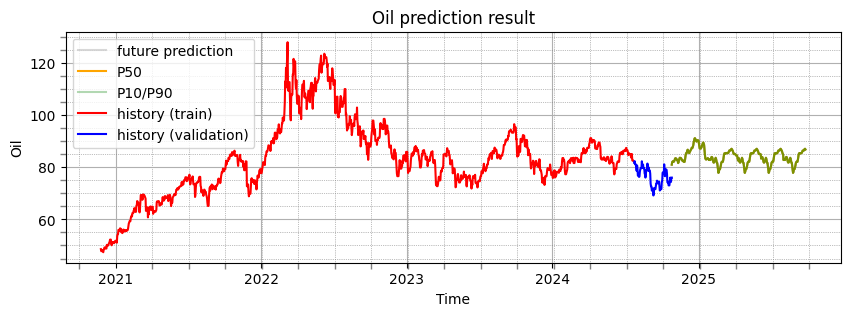

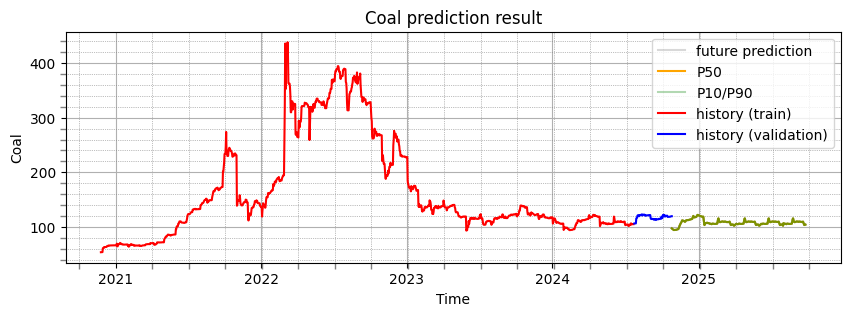

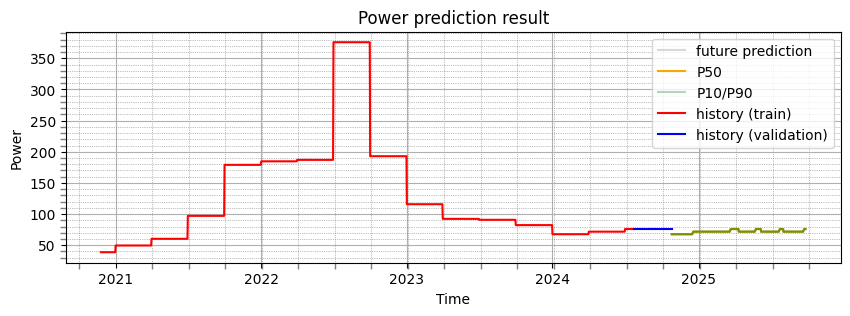

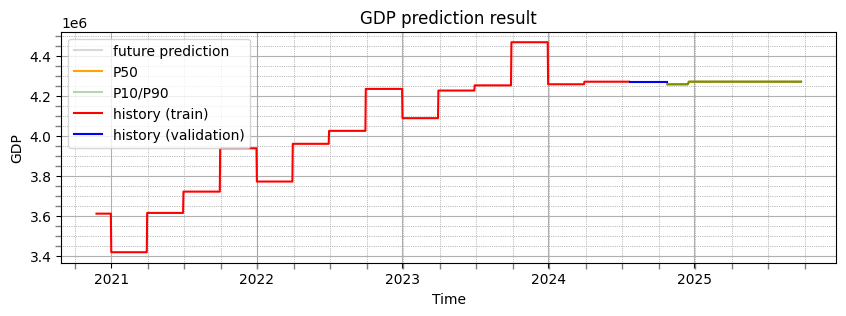

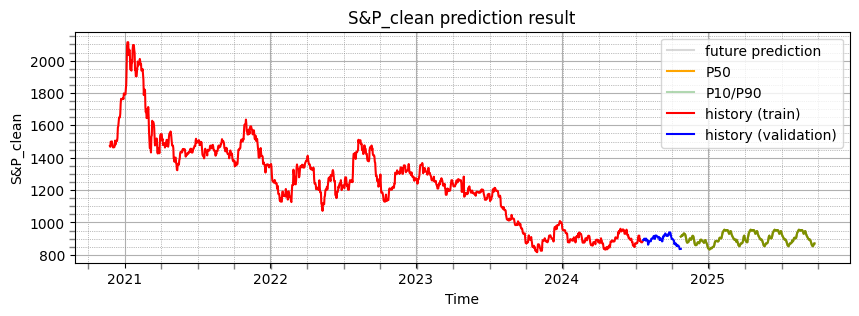

In [17]:
from script.post_processing import visual_recursive_future_prediction
for i, name in enumerate(['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean',]):
    visual_recursive_future_prediction(future_time, future_price_ensemble,
                                       train_test_split_date,
                                       df_all,
                                          figsize = (10,3),
                                          index_of_data= i, # 0 is EUA price
                                          name_of_data = name,
                                        decoration = {'xlabel': 'Time', 
                                                        'ylabel':name, 
                                                        'title':f'{name} prediction result',
                                                        'grid':'on'})
                                          